## Detect, Swap, & Blend 

In [1]:
#Name: Justin Garzione
#NetID: justing6

In [2]:
#Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from random import random
import time
import scipy
import scipy.sparse.linalg
import utils

[293, 322]


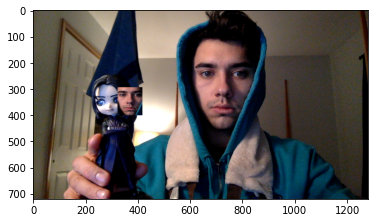

In [3]:
background_img = cv2.cvtColor(cv2.imread('./Images/opencv_frame_0.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
#plt.figure()
#plt.imshow(background_img)
#plt.show()
object_img = cv2.cvtColor(cv2.imread('./Images/object_0.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
#plt.imshow(object_img)
#plt.show()

xs = (10, 105, 105, 10)
ys = (20, 20, 128, 128)
object_mask = utils.get_mask(ys, xs, object_img)

#object_mask = np.ones((object_img.shape))


bottom_center = (370, 400) # (x,y)
object_img, object_mask = utils.crop_object_img(object_img, object_mask)

#BG_UL will be Upper left coordinate in background photo -> you have this stored in ys and xs
#Call this in y, x order and store as a tuple

bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
#print(bg_ul)

plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
object_mask[:,-1] = 0
object_mask[-1,:] = 0

#print(object_img.shape)
#plt.imshow(background_img[:,:,:])

In [5]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    #Object Shape
    im_h,im_w = object_mask.shape
    
    #Background upperleft coordinates
    bg_y, bg_x = bg_ul
    
    #Inner Dimensions
    smallh,smallw = (im_h-2,im_w-2)
    
    #Number of variables (Step 1)
    numVar = (object_mask>0).sum()

    #Number of Equations/Constraints = Inner Constraints + Outer Constraints
    neq = (smallh *(smallw-1) + smallw *(smallh-1)) + (2*(smallh+smallw))+1000000

    #Build Sparse Matrix with correct dimensions
    A = scipy.sparse.lil_matrix((neq, smallh*smallw), dtype='double') # init lil
    
    #Build Vector B
    b = np.zeros((neq,1), dtype='double')
    
    #Build im2var
    im2var = -np.ones(object_img.shape[0:2], dtype='int32')
    im2var[object_mask>0] = np.arange(numVar)
    #print(im2var)
    
    e = 0
    #Step 2
    #Inner Constraints - Horizontal
    for y in range(0,im_h):
        for x in range(0,im_w-1):
            if object_mask[y,x] == 1:
                A[e,im2var[y][x+1]] = -1
                A[e,im2var[y][x]] = 1
                b[e] = object_img[y][x] - object_img[y][x+1]
                e = e + 1
            
    #Inner Constraints - Vertical
    for y in range(0,im_h-1):
        for x in range(0,im_w):
            if object_mask[y,x] == 1:
                A[e,im2var[y+1][x]] = -1
                A[e,im2var[y][x]] = 1
                b[e] = object_img[y][x] - object_img[y+1][x] 
                e = e + 1
            
    #Outer Constraints - Vertical North
    for x in range(0,im_w):
        y = 1
        if object_mask[y,x] == 1:
            #A[e,im2var[y-1][x]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y-1][x] 
            b[e] = b[e] + bg_img[bg_y+(y-1)][bg_x+x]
            e = e + 1
            
    #Outer Constraints - Vertical South
    for x in range(0,im_w):
        y = im_h - 2
        if object_mask[y,x] == 1:
            #A[e,im2var[y+1][x]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y+1][x] 
            b[e] = b[e] + bg_img[bg_y+(y+1)][bg_x+x]
            e = e + 1
            
    #Outer Constraints - Horizontal East
    for y in range(0,im_h):
        x = im_w - 2
        if object_mask[y,x] == 1:
            #A[e,im2var[y][x+1]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y][x+1] 
            b[e] = b[e] + bg_img[bg_y+y][bg_x+(x+1)]
            e = e + 1
    
    #Outer Constraints - Horizontal West
    for y in range(0,im_h):
        x = 1
        if object_mask[y,x] == 1:
            #A[e,im2var[y][x-1]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y][x-1] 
            b[e] = b[e] + bg_img[bg_y+y][bg_x+(x-1)]
            e = e + 1
        
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr
    v2 = v[0].reshape(smallh,smallw)
    
    output = bg_img
    for y in range(0,smallh):
        for x in range(0,smallw):
            output[bg_y+y][bg_x+x] = v2[y][x]
    
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


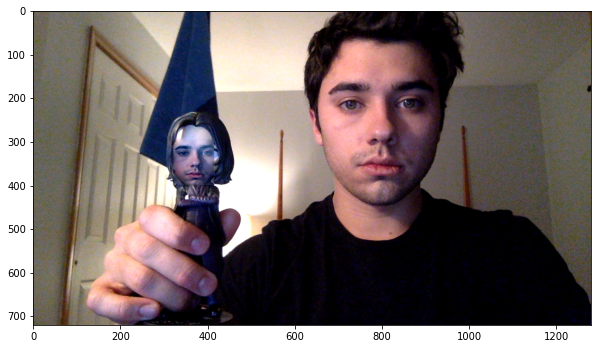

In [6]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)
plt.figure(figsize=(10,10))
plt.imshow(im_blend)